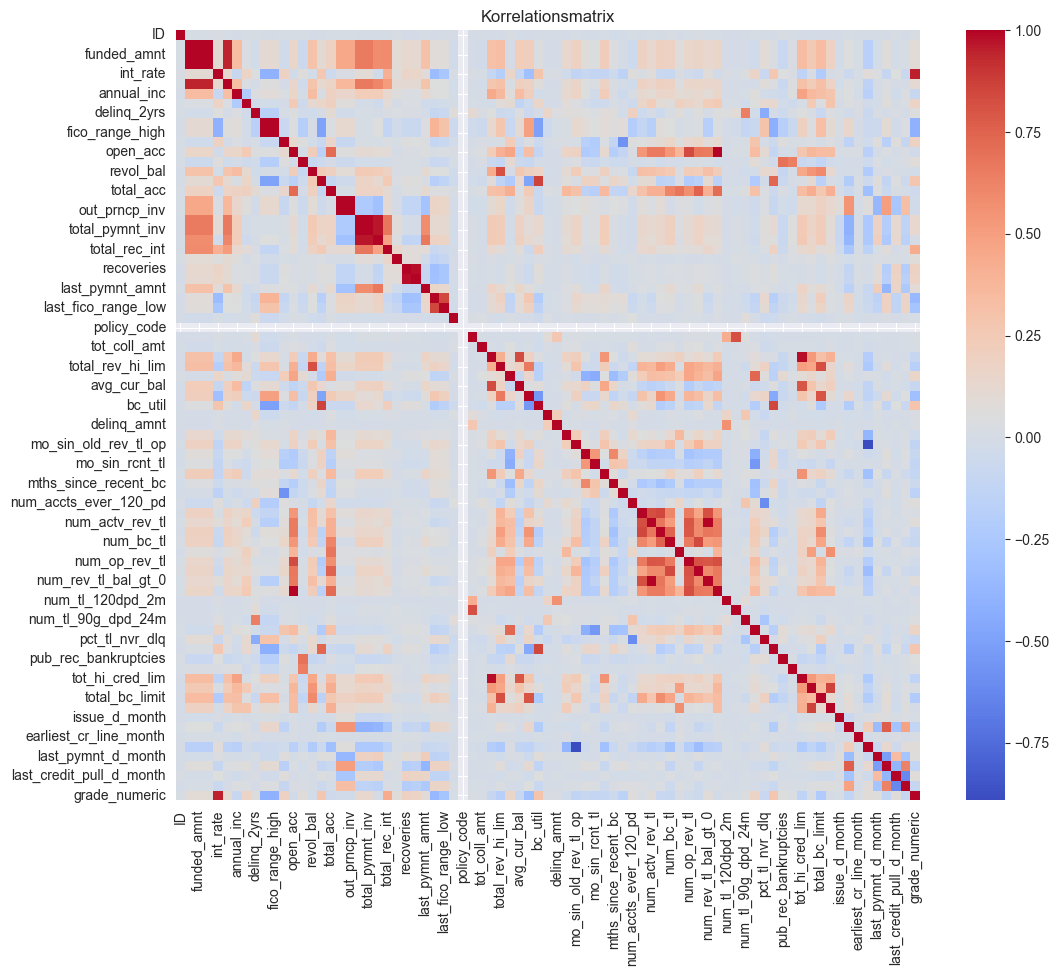

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load csv file with pandas
df = pd.read_csv('data/loan-10k.lrn.csv')

# drop all na values
df = df.dropna()

grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
numerical_df = df
numerical_df['grade_numeric'] = numerical_df['grade'].map(grade_mapping)
numerical_df.drop('ID', axis=1)

numerical_df = df.select_dtypes(include=[np.number])

# Berechne die Korrelationsmatrix
correlation_matrix = numerical_df.corr()


# Visualisiere die Korrelationsmatrix , annot=False
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Korrelationsmatrix")
plt.show()

# X and y
X = df.drop('grade', axis=1)  # shape: (n_samples, 8)
# y = df['grade'].values.reshape(-1, 1)  # shape: (n_samples, 1)
y = pd.get_dummies(df['grade']).astype(float).values


In [ ]:
#Preprocess dataset
date_prefixes = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
today = pd.Timestamp.today()
# today = pd.Timestamp().now().normalize()
# Transform the year and month columns into datetime
for prefix in date_prefixes:
    X[f'{prefix}_year'] = pd.to_numeric(X[f'{prefix}_year'], errors='coerce')
    X[f'{prefix}_month'] = pd.to_numeric(X[f'{prefix}_month'], errors='coerce')
    X[prefix] = pd.to_datetime(
        pd.DataFrame({
            'year': X[f'{prefix}_year'],
            'month': X[f'{prefix}_month'],
            'day': 1
        }),
        errors='coerce'
    )
    X[f'{prefix}_age_days'] = (today - X[prefix]).dt.days
    X[f'{prefix}_age_days'] = X[f'{prefix}_age_days'].fillna(X[f'{prefix}_age_days'].mean())

X = X.drop(columns=[f"{prefix}_year" for prefix in date_prefixes] +
                               [f"{prefix}_month" for prefix in date_prefixes],
                     errors='ignore')

# Drop original date columns
X = X.drop(columns=date_prefixes)

# Transform term column
if 'term' in X.columns:
    X['term'] = X['term'].str.extract(r'(\d+)').astype(float)

# Transform emp_length column
# emp_length: '< 1 year' etc.
emp_map = {'< 1 year': 0.5, '10+ years': 11}
X['emp_length'] = X['emp_length'].replace(emp_map)
X['emp_length'] = X['emp_length'].str.extract(r'(\d+)').astype(float).fillna(X['emp_length'])

# Transform binary flags
bin_map = {'N': 0, 'n': 0, 'Y': 1, 'y': 1}
for col in ['hardship_flag', 'debt_settlement_flag', 'pymnt_plan']:
    if col in X.columns:
        X[col] = X[col].map(bin_map)

# Transform categorical features
if 'disbursement_method' in X.columns:
    X['disbursement_method'] = X['disbursement_method'].map({'Cash': 0, 'DirectPay': 1})
if 'application_type' in X.columns:
    X['application_type'] = X['application_type'].map({'Individual': 0, 'Joint App': 1})
if 'initial_list_status' in X.columns:
    X['initial_list_status'] = X['initial_list_status'].map({'f': 0, 'w': 1})

# Transform Verification status
verification_map = {'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
if 'verification_status' in X.columns:
    X['verification_status'] = X['verification_status'].map(verification_map)

# loan_status (optional)
status_map = {
    'Fully Paid': 0,
    'Current': 1,
    'In Grace Period': 2,
    'Late (16-30 days)': 3,
    'Late (31-120 days)': 4,
    'Charged Off': 5
}
if 'loan_status' in X.columns:
    X['loan_status'] = X['loan_status'].map(status_map)

numerical_features = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
    'installment', 'emp_length', 'annual_inc', 'verification_status',
    'loan_status', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
    'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high',
    'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code',
    'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
    'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
    'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
    'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
    'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',
    'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
    'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
    'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
    'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
    'total_il_high_credit_limit'
]
numerical_features += [f'{prefix}_age_days' for prefix in date_prefixes]

categorical_features = ['purpose', 'home_ownership']

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features),
    ],
    remainder='drop'
)

X_processed = preprocessor.fit_transform(X)

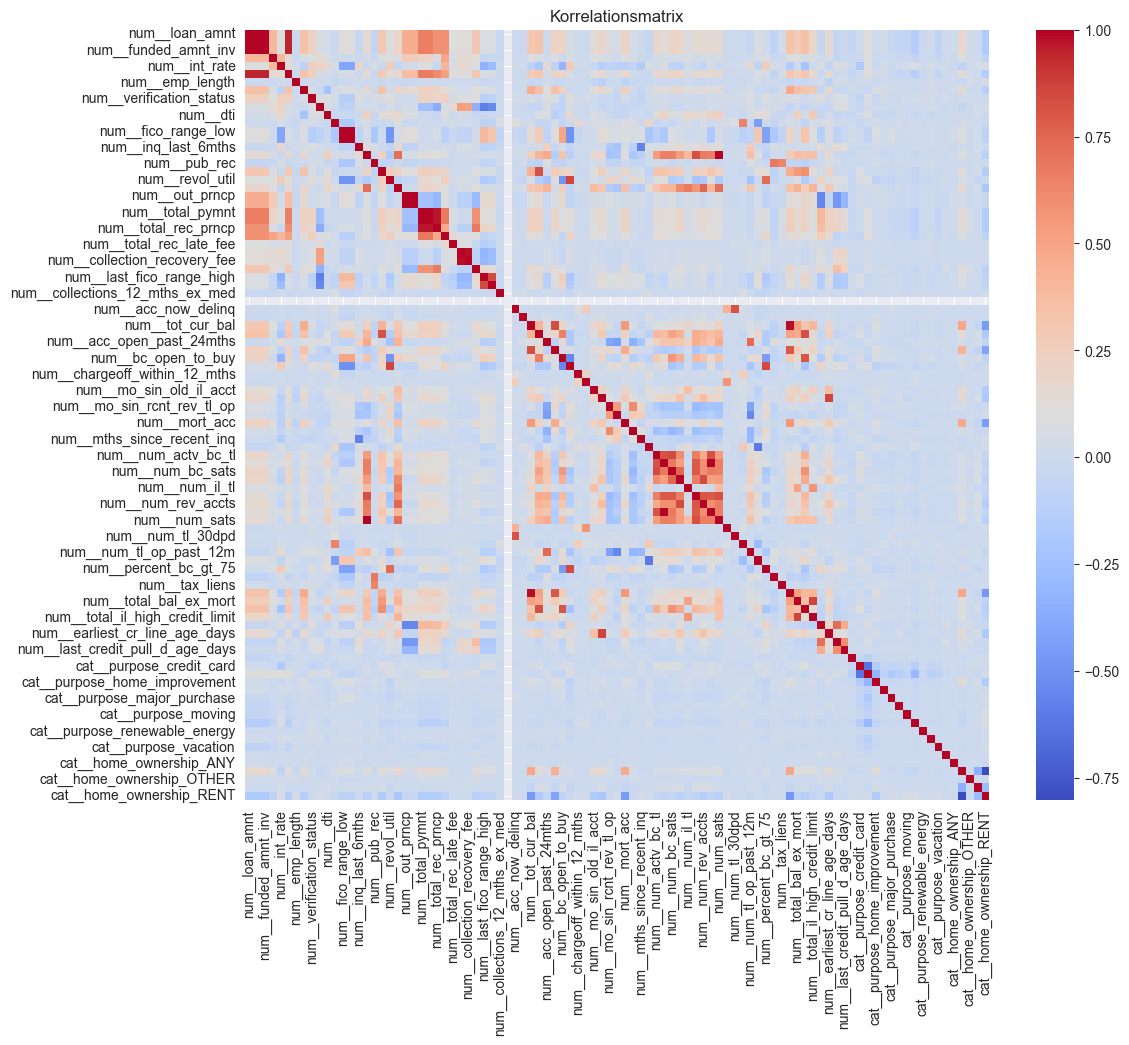

In [14]:
# Correlation Matrix to remove unnecessary features
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Konvertiere X_processed zurück in ein DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=preprocessor.get_feature_names_out())

# Berechne die Korrelationsmatrix
correlation_matrix = X_processed_df.corr()

# Visualisiere die Korrelationsmatrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Korrelationsmatrix")
plt.show()

In [10]:

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=123123)

print(X_train.shape)
print(y_train.shape)

(7000, 95)
(7000, 7)


### Train the model


=== Training Model 1/8 ===
Parameters: {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 7, 'lr': 0.05, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945910
           Test Accuracy = 0.2993
Epoch 10000: Loss = 0.136089
           Test Accuracy = 0.9253
Epoch 20000: Loss = 0.118205
           Test Accuracy = 0.9173
Epoch 30000: Loss = 0.108920
           Test Accuracy = 0.9180
Epoch 40000: Loss = 0.130232
           Test Accuracy = 0.9087
Epoch 50000: Loss = 0.110307
           Test Accuracy = 0.9130
Epoch 60000: Loss = 0.102156
           Test Accuracy = 0.9150

Stopped after epoch 65374. No improvement for 10000 epochs.


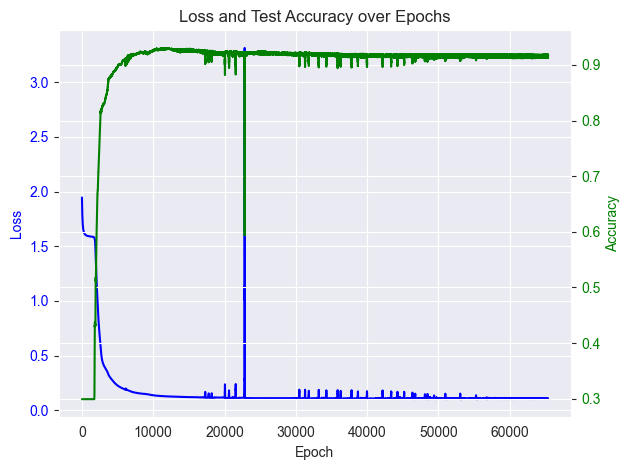


Minimum loss: 0.100542
Maximum test accuracy: 0.9303

=== Training Model 2/8 ===
Parameters: {'input_size': 95, 'hidden1_size': 62, 'hidden2_size': 42, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945919
           Test Accuracy = 0.2897
Epoch 10000: Loss = 0.338909
           Test Accuracy = 0.8623
Epoch 20000: Loss = 0.150953
           Test Accuracy = 0.9103
Epoch 30000: Loss = 0.097476
           Test Accuracy = 0.9093
Epoch 40000: Loss = 0.068804
           Test Accuracy = 0.9063
Epoch 50000: Loss = 0.049691
           Test Accuracy = 0.9033
Epoch 60000: Loss = 0.036555
           Test Accuracy = 0.9023
Epoch 70000: Loss = 0.027275
           Test Accuracy = 0.9017
Epoch 80000: Loss = 0.020697
           Test Accuracy = 0.8970
Epoch 90000: Loss = 0.015931
           Test Accuracy = 0.8970
Epoch 100000: Loss = 0.012419
           Test Accuracy = 0.8977
Epoch 110000: Loss = 0.009856
           Test Accuracy = 0.8957
Epoch 120000:

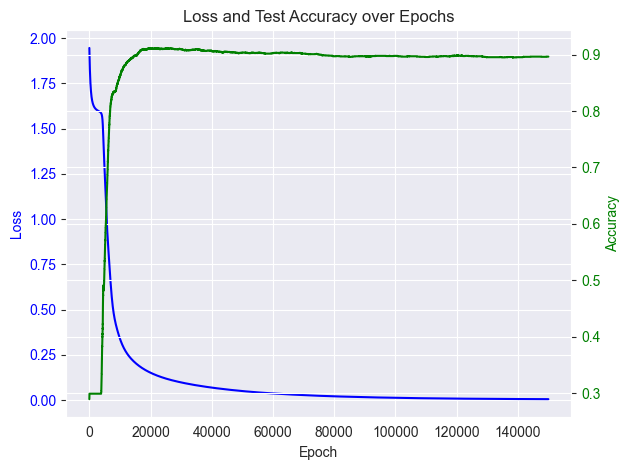


Minimum loss: 0.004967
Maximum test accuracy: 0.9117

=== Training Model 3/8 ===
Parameters: {'input_size': 95, 'hidden1_size': 90, 'hidden2_size': 75, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'relu', 'l2_lambda': 0.0001}
Epoch 0: Loss = 1.945948
           Test Accuracy = 0.2737
Epoch 10000: Loss = 0.291195
           Test Accuracy = 0.8840
Epoch 20000: Loss = 0.135962
           Test Accuracy = 0.9110
Epoch 30000: Loss = 0.088124
           Test Accuracy = 0.9133
Epoch 40000: Loss = 0.060828
           Test Accuracy = 0.9130
Epoch 50000: Loss = 0.042907
           Test Accuracy = 0.9100
Epoch 60000: Loss = 0.030801
           Test Accuracy = 0.9110
Epoch 70000: Loss = 0.022351
           Test Accuracy = 0.9087
Epoch 80000: Loss = 0.016492
           Test Accuracy = 0.9077
Epoch 90000: Loss = 0.012480
           Test Accuracy = 0.9083
Epoch 100000: Loss = 0.009671
           Test Accuracy = 0.9077
Epoch 110000: Loss = 0.007711
           Test Accuracy = 0.9070
Epoch 120000:

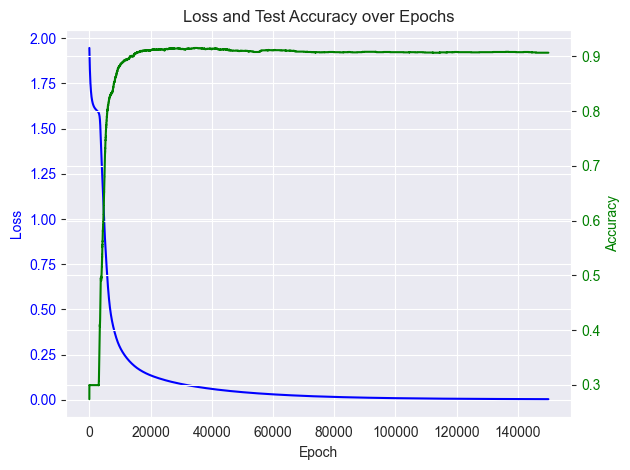


Minimum loss: 0.004172
Maximum test accuracy: 0.9153

=== Training Model 4/8 ===
Parameters: {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4, 'output_size': 7, 'lr': 0.01, 'activation_hidden': 'sigmoid'}


KeyError: 'l2_lambda'

In [13]:
import pandas as pd
import numpy as np

# Loss and Accuracy
from sklearn.metrics import accuracy_score
from Implementation.NeuralNetwork import NeuralNetwork
def train_model(model_params, X_train, y_train,
                X_test=None, y_test=None,
                max_epochs=30000,
                tolerance=1e-5,
                patience=10000,
                print_every=100):

    # Modell instanziieren
    model = NeuralNetwork(
        input_size=model_params['input_size'],
        hidden1_size=model_params['hidden1_size'],
        hidden2_size=model_params['hidden2_size'],
        output_size=model_params['output_size'],
        lr=model_params['lr'],
        activation_hidden=model_params['activation_hidden'],
        l2_lambda=model_params['l2_lambda'],
        multiclass=True if model_params['output_size'] > 1 else False
    )

    losses = []
    test_accuracies = []
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        loss = model.train(X_train, y_train)
        losses.append(loss)

        if X_test is not None and y_test is not None:
            y_test_proba = model.predict(X_test)
            # get integer-Labels 0..6 from the prediction via argmax
            y_pred_labels = np.argmax(y_test_proba, axis=1)
            # get true-label from the y_test
            y_true_labels = np.argmax(y_test, axis=1)
            # calc accuracy
            acc = accuracy_score(y_true_labels, y_pred_labels)
            test_accuracies.append(acc)

        if print_every and epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss = {loss:.6f}")
            if X_test is not None:
                print(f"           Test Accuracy = {acc:.4f}")

        if best_loss - loss > tolerance:
            best_loss = loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"\nStopped after epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Plot Loss und Test Accuracy
    fig, ax1 = plt.subplots()

    ax1.plot(losses, label="Train Loss", color='blue')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    if test_accuracies:
        ax2 = ax1.twinx()
        ax2.plot(test_accuracies, label="Test Accuracy", color='green')
        ax2.set_ylabel("Accuracy", color='green')
        ax2.tick_params(axis='y', labelcolor='green')

    plt.title("Loss and Test Accuracy over Epochs")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

    print(f"\nMinimum loss: {min(losses):.6f}")
    if test_accuracies:
        print(f"Maximum test accuracy: {max(test_accuracies):.4f}")

    return losses, test_accuracies




parameter_grid = [
    # Regularization
    # {'input_size': 95, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 0.1},
    # {'input_size': 95, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-4},
    # {'input_size': 95, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-3},
    # {'input_size': 95, 'hidden1_size': 32, 'hidden2_size': 16,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-2},


    # Neurons
    {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 7, 'lr': 0.05,  'activation_hidden': 'relu','l2_lambda': 1e-4}, # underfitting example
    {'input_size': 95, 'hidden1_size': 62, 'hidden2_size': 42,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-4}, # rule of thumb
    {'input_size': 95, 'hidden1_size': 90, 'hidden2_size': 75,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu', 'l2_lambda': 1e-4}, # overfitting example

    # activation functions
    {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'sigmoid'},
    {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'tanh'},

    # Learning rates
    {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 7, 'lr': 0.01,  'activation_hidden': 'relu'},
    {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 7, 'lr': 0.2,  'activation_hidden': 'relu'},
    {'input_size': 95, 'hidden1_size': 6, 'hidden2_size': 4,  'output_size': 7, 'lr': 0.001,  'activation_hidden': 'relu'}

]

results = []

for i, params in enumerate(parameter_grid):
    print(f"\n=== Training Model {i+1}/{len(parameter_grid)} ===")
    print(f"Parameters: {params}")

    losses, test_accuracies = train_model(
        params,
        X_train, y_train,
        X_test=X_test, y_test=y_test,
        max_epochs=150000,
        tolerance=1e-5,
        patience=10000,
        print_every=10000
    )

    results.append({
        'params': params,
        'min_loss': min(losses),
        'max_accuracy': max(test_accuracies) if test_accuracies else None
    })
